# Resource Management in Dask

This tutorial provides a summary of how to manage and utilise the CPU and memory effectively when dealing with large datasets and/or with intensive computation demands. There are several ways of managing larger than memory data and improving code efficiencies. The approaches below are demonstrated with some brief examples.
    
- Partition
    - dask.dataframe
    - dask.dataarray
- Save data onto disk
    - export intermediate data onto disk 
- Scheduler
    - Persist / Compute methods
    - Futures as pointers to remote data
    - Delayed
- Clear data
- Execution in background
    - Network communication example
    
----

- Authors: NCI Virtual Research Environment Team
- Keywords: Dask, Resource Management, Partition, Schedular
- Creation Date: 2020-Sep
-------

## 1. Partition 

Dask operates on chunks. Like what we see in examples of dask arrays and dataframes, Dask provides a parallel, larger-than-memory mechanism using blocked algorithms. Simply put: distributed operation on data series, frame, or array.

*  **Parallel**: Uses all of the cores on your computer
*  **Larger-than-memory**:  Lets you work on datasets that are larger than your available memory by breaking up your data into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
*  **Blocked Algorithms**:  Perform large computations by performing many smaller computations

A Dask DataFrame is composed of many pandas DataFrames. For `dask.dataframe` the chunking happens only along the index.

<img src="http://dask.pydata.org/en/latest/_images/dask-dataframe.svg" width="30%">

Dask arrays coordinate many Numpy arrays, arranged into chunks within a grid. They support a large subset of the Numpy API.

<img src="http://dask.pydata.org/en/latest/_images/dask-array-black-text.svg">

In this notebook, we'll build some understanding by implementing some blocked algorithms from scratch.

### Dask.DataFrame

In [7]:
import os
import dask
filename = os.path.join('/g/data/dk92/notebooks/demo_data/Weather_Stations_ACT','IDCJAC0009_*_*','IDCJAC0009*.csv')
filename

'/g/data/dk92/notebooks/demo_data/Weather_Stations_ACT/IDCJAC0009_*_*/IDCJAC0009*.csv'

In [8]:
import dask.dataframe as dd
ddf = dd.read_csv(filename)
ddf

,Product code,Bureau of Meteorology station number,Year,Month,Day,Rainfall amount (millimetres),Period over which rainfall was measured (days),Quality
npartitions=125,,,,,,,,
,object,int64,int64,int64,int64,float64,float64,object
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [3]:
ddf.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Rainfall amount (millimetres),Period over which rainfall was measured (days),Quality
0,IDCJAC0009,42010,2015,1,1,0.0,NaN,Y
1,IDCJAC0009,42010,2015,1,2,20.0,1.0,Y
2,IDCJAC0009,42010,2015,1,3,15.2,1.0,Y
3,IDCJAC0009,42010,2015,1,4,0.0,NaN,Y
4,IDCJAC0009,42010,2015,1,5,0.0,NaN,Y


In [7]:
dd.groupby("Product code")["Rainfall amount (millimetres)"].max().visualize(filename='dataframe_graph.pdf')

### Dask.dataarray

To open multiple files simultaneously in parallel using Dask delayed, use `open_mfdataset()`.

This function will automatically concatenate and merge datasets into one in the simple cases that it understands (see `combine_by_coords()` for the full disclaimer). By default, `open_mfdataset()` will chunk each netCDF file into a single Dask array; again, supply the chunks argument to control the size of the resulting Dask arrays. In more complex cases, you can open each file individually using `open_dataset()` and merge the result, as described in the Combining data xarray tutorial. Passing the keyword argument `parallel=True` to `open_mfdataset()` will speed up the reading of large multi-file datasets by executing those read tasks in parallel using `dask.delayed`.

In [1]:
import xarray as xr
import dask.array as da
path = '/g/data/oi10/replicas/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM4/ssp585/r1i1p1f1/day/pr/gr1/v20180701/*'
f_ssp585 = xr.open_mfdataset(path)
# Use Dask.Distributed utility function to display size of each dataset
from distributed.utils import format_bytes
print(
    "ssp585:",
    format_bytes(f_ssp585.nbytes),
)
dsets = xr.open_mfdataset(path,chunks={'time':730},parallel=True)
dsets

ssp585: 6.74 GB


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 31390)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time       (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(7300, 180, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(7300, 288, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(730, 180, 288), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(730, 2), meta=np.ndarray>
Attributes:
    external_variables:     areacella
    history:                File was processed by fremetar (GFDL analog of CM...
    table_id:               day
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    comment:                <null ref>
    contact:                gfdl.climate.model.info@noaa.gov
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    creation_date:          2019-03-18T15:13:56Z
    data_specs_version:     01.00.27
    experiment:             update of RCP8.5 based on SSP5
    experiment_id:          ssp585
    forcing_index:          1
    frequency:              day
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NOAA-GFDL.GF...
    grid:                   atmos data regridded from Cubed-sphere (c96) to 1...
    grid_label:             gr1
    initialization_index:   1
    institution:            National Oceanic and Atmospheric Administration, ...
    institution_id:         NOAA-GFDL
    license:                CMIP6 model data produced by NOAA-GFDL is license...
    mip_era:                CMIP6
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   historical
    parent_mip_era:         CMIP6
    parent_source_id:       GFDL-CM4
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  atmos
    source:                 GFDL-CM4 (2018): \naerosol: interactive\natmos: G...
    source_id:              GFDL-CM4
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    title:                  NOAA GFDL GFDL-CM4 model output prepared for CMIP...
    tracking_id:            hdl:21.14100/ad8c930c-124f-4b82-98b2-98cc4236ba25
    variable_id:            pr
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1
    branch_time_in_parent:  60225.0
    parent_time_units:      days since 1850-1-1

You'll notice that printing a dataset still shows a preview of array values, even if they are actually Dask arrays. We can do this quickly with Dask because we only need to compute the first few values (typically from the first block). To reveal the true nature of an array, print a DataArray:

In [2]:
dsets.pr

,Array,Chunk
Bytes,6.51 GB,151.37 MB
Shape,"(31390, 180, 288)","(730, 180, 288)"
Count,91 Tasks,43 Chunks
Type,float32,numpy.ndarray


Once you've manipulated a Dask array, you can still write a dataset too big to fit into memory back to disk by using `to_netcdf()` in the usual way. Be mindful the following cell will take some time. 

In [ ]:
# Use a location you have write access to
dsets.to_netcdf("/g/data/dk92/notebooks/demo_data/cmip6-precipitation-data.nc")

Alternatively, by setting the compute argument to `False`, `to_netcdf()` will return a `dask.delayed` object that can be computed later.

In [5]:
from dask.diagnostics import ProgressBar

# or distributed.progress when using the distributed scheduler
delayed_obj = dsets.to_netcdf("/g/data/dk92/notebooks/demo_data/cmip6-precipitation-data.nc", compute=False)

with ProgressBar():
    results = delayed_obj.compute()

/g/data/dk92/packages/xarray/conventions.py:427: UserWarning: Variable 'time' has datetime type and a bounds variable but time.encoding does not have units specified. The units encodings for 'time' and 'time_bnds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 'time' before writing to a file.
  UserWarning,


[########################################] | 100% Completed | 15min 27.7s


When we do a small scale caculation, reading the whole file into memory is intuitive, but this approach often does not scale. Then segmentation and working on big data bit by bit is a good practice when dealing with larger-than-memory data.  Note that there is often a trade-off between time-efficiency and memory footprint: the following uses very little memory, but may be slower for files that do not fill a large faction of memory. In general, one would like chunks small enough not to stress memory, but big enough for efficient use of the CPU. 

## 2. Save data onto disk

Whenever we operate on our data we read through all of our data so that we don’t fill up RAM. This is very efficient for memory use, but reading through all of the data files every time can be slow.

As you saw in the dask dataframes example, we stored our data in Parquet, a format that is more efficient for computers to read and write. It is binary file format. Parquet stores nested data structures in a flat columnar format. Compared to a traditional approach where data is stored in row-oriented approach, parquet is more efficient in terms of storage and performance.

The following code was copied from that example to remind you one way of how to save data onto disk.

In [12]:
# Write data as parquet format
ddf.to_parquet('/g/data/dk92/notebooks/demo_data/ACT_weather.parquet', engine='pyarrow')
!ls ../demo_data/ACT_weather.parquet

_common_metadata  part.14.parquet  part.43.parquet  part.72.parquet
_metadata	  part.15.parquet  part.44.parquet  part.73.parquet
part.0.parquet	  part.16.parquet  part.45.parquet  part.74.parquet
part.100.parquet  part.17.parquet  part.46.parquet  part.75.parquet
part.101.parquet  part.18.parquet  part.47.parquet  part.76.parquet
part.102.parquet  part.19.parquet  part.48.parquet  part.77.parquet
part.103.parquet  part.1.parquet   part.49.parquet  part.78.parquet
part.104.parquet  part.20.parquet  part.4.parquet   part.79.parquet
part.105.parquet  part.21.parquet  part.50.parquet  part.7.parquet
part.106.parquet  part.22.parquet  part.51.parquet  part.80.parquet
part.107.parquet  part.23.parquet  part.52.parquet  part.81.parquet
part.108.parquet  part.24.parquet  part.53.parquet  part.82.parquet
part.109.parquet  part.25.parquet  part.54.parquet  part.83.parquet
part.10.parquet   part.26.parquet  part.55.parquet  part.84.parquet
part.110.parquet  part.27.parquet  part.56.parquet  part

Extract binary files from disk and do some calcuation with a better performance gain:

In [37]:
%%time 
import pandas as pd
df = pd.read_parquet('/g/data/dk92/notebooks/demo_data/ACT_weather.parquet', engine='pyarrow')
df["Rainfall amount (millimetres)"].max()

CPU times: user 661 ms, sys: 282 ms, total: 943 ms
Wall time: 787 ms


322.1

## 3. Scheduler

### Persist sends work to the scheduler

In [18]:
# If you run this notebook on your local computer or NCI's VDI instance, you can create cluster
from dask.distributed import Client
client = Client()
print(client)

/apps/dask/2.19.0-py3.7/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45269 instead
  http_address["port"], self.http_server.port


<Client: 'tcp://127.0.0.1:33613' processes=4 threads=8, memory=33.56 GB>


In [ ]:
# If you run this notebook on Gadi under pangeo environment, you can create cluster using scheduler.json file
from dask.distributed import Client, LocalCluster
client = Client(scheduler_file='../scheduler.json')
print(client)

<div class="alert alert-info">
<b>Warning: Please make sure you specify the correct path to the scheduler.json file within your environment.</b>  
</div>

Starting the Dask Client will provide a dashboard which is useful to gain insight into the computation. The link to the dashboard will become visible when you create the Client. We recommend having the Client open on one side of your screen and your notebook open on the other side, which will be useful for learning purposes.

In [1]:
# read csv files again
import os
import dask
filename = os.path.join('/g/data/dk92/notebooks/demo_data/Weather_Stations_ACT','IDCJAC0009_*_*','IDCJAC0009*.csv')
import dask.dataframe as dd
ddf = dd.read_csv(filename)
ddf.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Rainfall amount (millimetres),Period over which rainfall was measured (days),Quality
0,IDCJAC0009,42010,2015,1,1,0.0,NaN,Y
1,IDCJAC0009,42010,2015,1,2,20.0,1.0,Y
2,IDCJAC0009,42010,2015,1,3,15.2,1.0,Y
3,IDCJAC0009,42010,2015,1,4,0.0,NaN,Y
4,IDCJAC0009,42010,2015,1,5,0.0,NaN,Y


In [2]:
df = ddf[ddf["Rainfall amount (millimetres)"]> 20]
df.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Rainfall amount (millimetres),Period over which rainfall was measured (days),Quality
14,IDCJAC0009,42010,2015,1,15,38.2,1.0,Y
27,IDCJAC0009,42010,2015,1,28,34.0,1.0,Y
236,IDCJAC0009,42010,2015,8,25,23.5,1.0,Y
309,IDCJAC0009,42010,2015,11,6,24.0,1.0,Y
319,IDCJAC0009,42010,2015,11,16,22.0,1.0,Y


In [88]:
len(df)

36680

In [89]:
df = client.persist(df)

### Futures Point to Remote Data

In [90]:
from dask.distributed import futures_of

futures_of(df)

[<Future: finished, type: pandas.DataFrame, key: ('getitem-d16bbed9ccf19bd078afb71e4c1c2cde', 0)>,
 <Future: finished, type: pandas.DataFrame, key: ('getitem-d16bbed9ccf19bd078afb71e4c1c2cde', 1)>,
 <Future: finished, type: pandas.DataFrame, key: ('getitem-d16bbed9ccf19bd078afb71e4c1c2cde', 2)>,
 <Future: finished, type: pandas.DataFrame, key: ('getitem-d16bbed9ccf19bd078afb71e4c1c2cde', 3)>,
 <Future: finished, type: pandas.DataFrame, key: ('getitem-d16bbed9ccf19bd078afb71e4c1c2cde', 4)>,
 <Future: finished, type: pandas.DataFrame, key: ('getitem-d16bbed9ccf19bd078afb71e4c1c2cde', 5)>,
 <Future: finished, type: pandas.DataFrame, key: ('getitem-d16bbed9ccf19bd078afb71e4c1c2cde', 6)>,
 <Future: finished, type: pandas.DataFrame, key: ('getitem-d16bbed9ccf19bd078afb71e4c1c2cde', 7)>,
 <Future: finished, type: pandas.DataFrame, key: ('getitem-d16bbed9ccf19bd078afb71e4c1c2cde', 8)>,
 <Future: finished, type: pandas.DataFrame, key: ('getitem-d16bbed9ccf19bd078afb71e4c1c2cde', 9)>,
 <Future: 

Dask holds onto data for which a future exists:

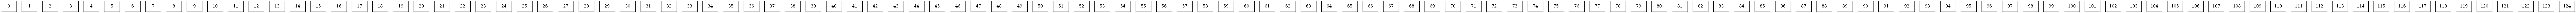

In [91]:
df.visualize()

### Delayed feature provides non-Dask results

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.809322 to fit


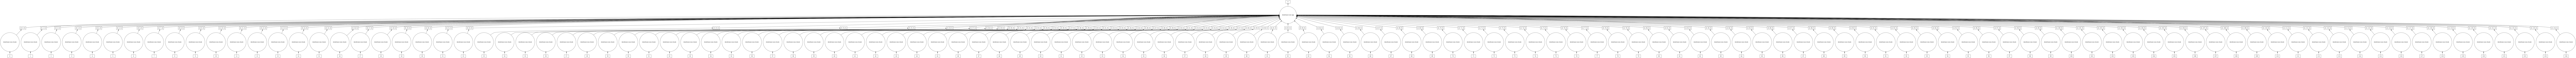

In [92]:
df.sum().visualize()

In [95]:
df["Rainfall amount (millimetres)"].sum().compute()

1236652.3

## 4. Clearing data

We remove data from distributed RAM by removing the collection from our local process. Remote data is removed once all Futures pointing to that data are removed from all client machines.

In [3]:
del df  # Deleting local data often deletes remote data

If this is the only copy then this will likely trigger the cluster to delete the data as well.

However if we have multiple copies or other collections based on this one then we’ll have to delete them all.

In [5]:
import dask.dataframe as dd
df = dd.read_csv(filename)
df2 = df[df["Rainfall amount (millimetres)"] < 10]
del df2  # would not delete data, because df2 still tracks the futures

In [6]:
df

,Product code,Bureau of Meteorology station number,Year,Month,Day,Rainfall amount (millimetres),Period over which rainfall was measured (days),Quality
npartitions=125,,,,,,,,
,object,int64,int64,int64,int64,float64,float64,object
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


### Aggressively Clearing Data

To definitely remove a computation and all computations that depend on it you can always cancel the futures/collection.

In [12]:
client.cancel(df)  # kills df, df2, and every other dependent computation

Alternatively, if you want a clean slate, you can restart the cluster. This clears all state and does a hard restart of all worker processes. It generally completes in around a second.

In [16]:
client.restart()

Client Scheduler: tcp://10.6.42.26:8720 Dashboard: http://10.6.42.26:8764/status,Cluster Workers: 96 Cores: 96 Memory: 322.12 GB


## 5. Execution in the background

There are many tasks that take a while to complete, but don't actually require much of the CPU, for example anything that requires communication over a network, or input from a user. In typical sequential programming, execution would need to halt while the process completes, and then continue execution. That would be dreadful for a user experience (imagine the slow progress bar that locks up the application and cannot be cancelled), and wasteful of time (the CPU could have been doing useful work in the meantime).
For example, we can launch processes and get their output as follows:
```python
    import subprocess
    p = subprocess.Popen(command, stdout=subprocess.PIPE)
    p.returncode
```
The task is run in a separate process, and the return-code will remain `None` until it completes, when it will change to `0`. To get the result back, we need `out = p.communicate()[0]` (which would block if the process was not complete).

Similarly, we can launch Python processes and threads in the background. Some methods allow mapping over multiple inputs and gathering the results. The thread starts and the cell completes immediately, but the data associated with the download only appears in the queue object some time later.

In [111]:
# This cell calls data as a remote file using the OPeNDAP protocol

import threading
import queue
import urllib

def get_webdata(url, q):
    u = urllib.request.urlopen(url)
    # raise ValueError
    q.put(u.read())

q = queue.Queue()
t = threading.Thread(target=get_webdata, args=('http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-0/1pctCO2/day/atmos/day/r1i1p1/latest/pr/pr_day_ACCESS1-0_1pctCO2_r1i1p1_03000101-03241231.nc.html', q))
t.start()

**Note:** the cell above won't work if you run this using Pangeo on Gadi as the compute notes do have external internet access, but will work on VDI, login nodes, or local PC. 

In [112]:
# Fetch result back into this thread. If the worker thread is not done, this would wait.
q.get()

b'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN"\n"http://www.w3.org/TR/REC-html40/loose.dtd">\n<html><head><title>OPeNDAP Dataset Query Form</title>\n<link type="text/css" rel="stylesheet" media="screen" href="/thredds/tdsDap.css"/>\n<base href="http://www.opendap.org/online_help_files/">\n<script type="text/javascript">\n<!--\n\n\n// -*- Java -*-\n\n// $Id: jscriptCore.java 15901 2007-02-28 23:57:28Z jimg $\n\n// (c) COPYRIGHT URI/MIT 1999\n// Please read the full copyright statement in the file COPYRIGHT.\n//\n// Authors:\n//\tjhrg,jimg\tJames Gallagher (jgallagher@gso.url.edu)\n\nvar reflection_cgi = "http://unidata.ucar.edu/cgi-bin/dods/posturl.pl";\n\n// Event handlers for the disposition button.\n\n// The ascii_button handler sends data to a new window. The user can then \n// save the data to a file.\n\nfunction ascii_button() {\n    var url = new String(document.forms[0].url.value);\n\n    var url_parts = url.split("?");\n    /* handle case where constraint is nu

**Consider:** What would you see if there had been an exception within the `get_webdata` function? You could uncomment the `raise` line, above, and re-execute the two cells. What happens? Is there any way to debug the execution to find the reason?

### Summary

This example summarizes some basic strategies of using chunks, dask lazy excution, schedulers, futures and persist utilities for a better performance.

Reference
https://docs.dask.org/